# 

In [1]:
import numpy as np
import bayes3d as b
from tqdm import tqdm
import jax
import jax.numpy as jnp
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
import matplotlib.pyplot as plt
import os
from functools import partial
from PIL import Image
import cv2

from mpl_toolkits.axes_grid1 import make_axes_locatable

from carvekit.api.high import HiInterface
import torch

import jaxopt
from jaxopt import OptaxSolver
import optax

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [2]:
# more objects, make grid 5

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
def projection(x=0.1, n=1.0, f=50.0):
    return jnp.array([[n/x,    0,            0,              0],
                      [  0,  n/x,            0,              0],
                      [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                      [  0,    0,           -1,              0]])

def translate(x, y, z):
    return jnp.array([[1.0, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])

def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)

def random_angles(key):
    theta_key, phi_key, omega_key = jax.random.split(key, 3)
    theta = jax.random.choice(theta_key, jnp.linspace(0, 2*jnp.pi, 100))
    phi   = jax.random.choice(phi_key, jnp.linspace(0, 2*jnp.pi, 100))
    omega = jax.random.choice(omega_key, jnp.linspace(0, 2*jnp.pi, 100))
    return theta, phi, omega

def random_translation(key, bbox_len):
    x_key, y_key, z_key = jax.random.split(key, 3)
    translation = jnp.array([0.0, 0.0, -3.2])
    x_del = jax.random.choice(x_key, jnp.linspace(-bbox_len, bbox_len, 100))
    y_del = jax.random.choice(y_key, jnp.linspace(-bbox_len, bbox_len, 100))
    z_del = jax.random.choice(z_key, jnp.linspace(-bbox_len, bbox_len, 100))
    return translation + jnp.array([x_del, y_del, z_del])

def spherical_to_cartesian(theta, phi):
    return jnp.array([jnp.sin(phi)*jnp.cos(theta),
                      jnp.sin(phi)*jnp.sin(theta),
                      jnp.cos(phi)])

def stereo_to_rot(stereo):
    q0, q1, q2, q3 = stereo_to_cartesian(stereo)
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    return jnp.array([[r00, r01, r02],
                      [r10, r11, r12],
                      [r20, r21, r22]])

def get_verts_and_faces(id):
    model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(id).rjust(6, '0') + ".ply")
    mesh = b.utils.scale_mesh(b.utils.load_mesh(mesh_path), 1.0/1.0)
    verts, faces = map(jnp.array, (mesh.vertices, mesh.faces))
    return verts, faces

In [5]:
#mvp = jnp.matmul(projection(x=0.4), translate(0, 0, 0.0))
intrinsics = b.Intrinsics(
    height=240,
    width=424,
    fx=216.0, fy=216.0,
    cx=424.0/2, cy=240.0/2,
    near=0.01, far=2000.5
)
jax_renderer = JaxRenderer(intrinsics)

verts_and_faces_list = [get_verts_and_faces(i) for i in range(10,15)]
num_objs = len(verts_and_faces_list)
banana_idx, pitcher_idx, dishsoap_idx, bowl_idx, mug_idx = range(num_objs)

In [6]:
def render_obj_pose(pose, verts, faces):
    img = jax_renderer.render(verts, faces, pose, intrinsics)[0][0,...]
    return img
    
# theta, phi = spherical coordinates
# omega = rotation angle
def render_obj_axis_angle(translation, theta, phi, omega, verts, faces):
    axis = spherical_to_cartesian(theta, phi)
    pose = b.transform_from_rot_and_pos(b.rotation_from_axis_angle(axis, omega),
                                        translation)
    return render_obj_pose(pose, verts, faces)

def render_obj_quat(translation, quat, verts, faces):
    rot = b.quaternion_to_rotation_matrix(quat)
    pose = b.transform_from_rot_and_pos(rot, translation)
    return render_obj_pose(pose)

def render_obj_stereo(translation, stereo, verts, faces):
    rot = stereo_to_rot(stereo)
    pose = b.transform_from_rot_and_pos(rot, translation)
    return render_obj_pose(pose)

In [7]:
key = jax.random.PRNGKey(2)

In [8]:
# b.show_cloud('mug', verts_and_faces_list[gt_id][0])
# translation = jnp.array([0.0, 0.0, -2])
# axis = spherical_to_cartesian(0, jnp.pi/2)
# omega = jnp.pi
# b.show_pose('cam', jnp.linalg.inv(b.transform_from_rot_and_pos(b.rotation_from_axis_angle(axis, omega), translation)))

In [9]:
 # b.utils.aabb(verts_and_faces_list[gt_id][0])

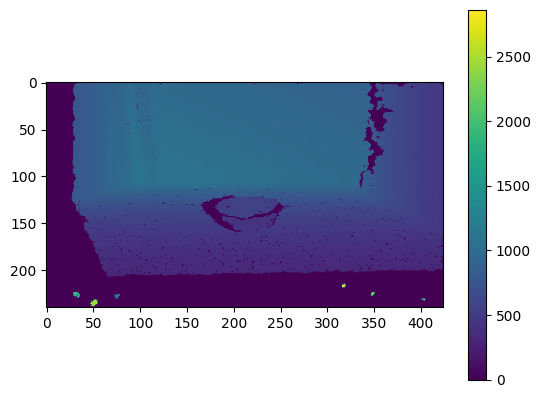

In [10]:
input_file_depth = 'realsense_opt_proj_data_v2/bowl_Depth.raw'
input_file_rgb = 'realsense_opt_proj_data_v2/bowl_Color.png'
depth_img = np.fromfile(input_file_depth, dtype=np.uint16)
depth_img = depth_img.reshape((240, 424))

im_frame = Image.open(input_file_rgb)
color_img = np.array(im_frame.getdata()).reshape(im_frame.size[1],im_frame.size[0], 3)

plt.imshow(depth_img)
plt.colorbar()

In [11]:
def fit_plane(pc):
    centroid = jnp.mean(pc, axis=0)
    pc = pc - centroid
    normal = jnp.linalg.svd(pc.T @ pc)[0][:, 2]
    return centroid, normal

In [12]:
@jax.jit
def ransac_plane(key, pc, sample_size=5, epsilon=0.1, num_iters=100):
    best_fit, best_coverage = None, float('-inf')
    def ransac_run(key):
        sample =  jax.random.choice(key, pc, replace=False, shape=(sample_size,))
        point, normal = fit_plane(sample)
        coverage = jnp.sum(jnp.abs((pc - point) @ normal) < epsilon)
        return point, normal, coverage
    points, normals, coverages = jax.vmap(ransac_run)(jax.random.split(key, num_iters))
    best_run_idx = jnp.argmax(coverages)
    return points[best_run_idx], normals[best_run_idx]

In [13]:
def clean_depth_img(depth_img):
    t = 600 # back_wall_threshold 
    cleaned_depth_img = jnp.zeros_like(depth_img)
    cleaned_depth_img = cleaned_depth_img.at[depth_img < t].set(depth_img[depth_img < t])
    cleaned_depth_img = cleaned_depth_img.at[:, 350:].set(0)
    cleaned_pc = b.unproject_depth(cleaned_depth_img, intrinsics).reshape(-1, 3)
    cleaned_pc = cleaned_pc[cleaned_pc[:, 2] < 1750]
    floor_point, floor_normal = ransac_plane(key, cleaned_pc)
    floor_mask = jnp.abs((cleaned_pc - floor_point) @ floor_normal) < 10
    #b.show_cloud('pc', cleaned_pc/1000)
    #b.show_cloud('floor', cleaned_pc[floor_mask, :]/1000, b.RED)
    cleaned_pc = cleaned_pc[~floor_mask, :]
    cleaned_depth_img = jnp.zeros_like(cleaned_depth_img)
    pixel_idxs = b.project_cloud_to_pixels(cleaned_pc, intrinsics).astype(jnp.int32)
    cleaned_depth_img = cleaned_depth_img.at[pixel_idxs[:, 1], pixel_idxs[:, 0]].set(cleaned_pc[:, 2])
    return cleaned_depth_img

cleaned_depth_img = clean_depth_img(depth_img)

/opt/conda/envs/bayes3d/lib/python3.9/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=uint16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


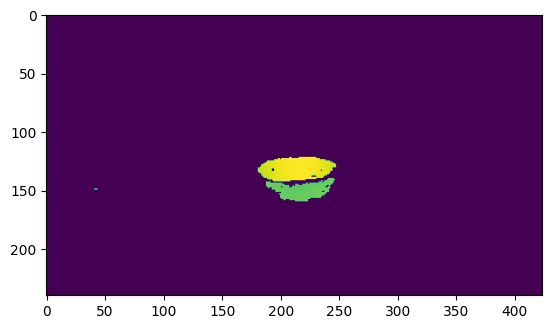

In [14]:
plt.imshow(cleaned_depth_img)

In [15]:
def lpf(img, window_size, sigma):
#filter = jnp.ones((window_size, window_size)) / window_size
    f = lambda x: jax.scipy.stats.multivariate_normal.pdf(x, jnp.zeros(2), sigma*jnp.eye(2))
    gaussian_filter = f(jnp.hstack([v.reshape(-1, 1) for v in jnp.meshgrid(jnp.arange(-window_size, window_size+1),
                                                              jnp.arange(-window_size, window_size+1))]))
    gaussian_filter = gaussian_filter.reshape(2*window_size+1, 2*window_size+1)
    return jax.scipy.signal.convolve2d(img, gaussian_filter, mode='same')

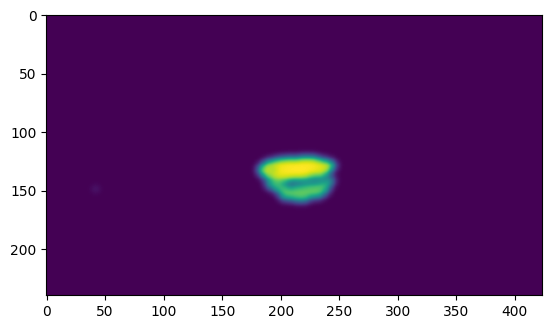

In [17]:
plt.imshow(lpf(cleaned_depth_img, 10, 10))

In [18]:
pc = b.t3d.unproject_depth(cleaned_depth_img, intrinsics).reshape(-1, 3)
foreground_pc = pc[pc[:, 2] < 1800, :]

In [19]:
init_tran = jnp.median(foreground_pc, axis=0)
#b.show_pose('center pose',  b.t3d.transform_from_pos(init_tran))

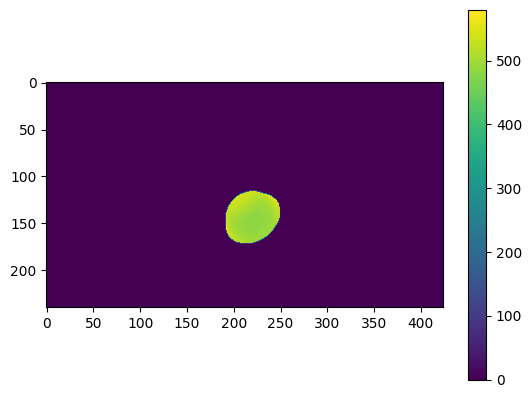

In [20]:
key = jax.random.split(key, 2)[0]
img = render_obj_axis_angle(init_tran, *random_angles(key),
                            *verts_and_faces_list[bowl_idx])
plt.imshow(img)
plt.colorbar()

In [21]:
grid_size = 3
thetas = jnp.linspace(0, 2*jnp.pi, grid_size)
phis   = jnp.linspace(0, jnp.pi/2, grid_size)
omegas = jnp.linspace(0, 2*jnp.pi, grid_size)

In [22]:
base_translation = init_tran
bbox_len = 0.05
xs = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[0]
ys = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[1]
zs = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[2]
init_params_meshgrid = jnp.meshgrid(thetas, phis, omegas, xs,ys,zs, indexing='ij')
init_params_meshgrid = jnp.array(init_params_meshgrid).reshape(6,-1)
init_params_array = init_params_meshgrid.T

In [23]:
def loss_fn_axis_angle(params, verts, faces, gt_img):
    theta, phi, omega, t_x, t_y, t_z = params
    translation = jnp.array([t_x, t_y, t_z])
    img = render_obj_axis_angle(translation, theta, phi, omega, verts, faces)
    return jnp.mean(jnp.abs(lpf(gt_img, 5, 5) - lpf(img, 5, 5)))

In [24]:
lr = 1e-5
num_steps = 2000
num_inits = len(init_params_array)

def estimate_pose(gt_img, init_params_array):
    def optimize(verts, faces, init_params):
        opt = optax.adam(lr)
        solver = OptaxSolver(opt=opt, fun=loss_fn_axis_angle, maxiter=10000)
        init_state = solver.init_state(init_params, verts=verts, faces=faces, gt_img=gt_img)
        def opt_step(i, loop_state):
            params, state, losses = loop_state
            params, state = solver.update(params, state, gt_img=gt_img, verts=verts, faces=faces)
            losses = losses.at[i].set(state.value)
            return params, state, losses 
        params, _, losses = jax.lax.fori_loop(0, num_steps, opt_step, (init_params, init_state, jnp.zeros(num_steps)))
        return losses, params
        
    def optimize_all(i, loop_state):
        jax.debug.print('{i}', i=i)
        loss_trajs, final_losses, final_params = loop_state
        for (obj_id, (verts, faces)) in enumerate(verts_and_faces_list):
            init_params = jax.lax.dynamic_slice(init_params_array, (i, 0), (1, 6)).flatten()
            losses, params = optimize(verts, faces, init_params)
            loss_trajs = loss_trajs.at[i, obj_id, :].set(losses)
            final_losses = final_losses.at[i, obj_id].set(losses[-1])
            final_params = final_params.at[i, obj_id, :].set(params)
        return loss_trajs, final_losses, final_params
        
    final_losses = jnp.zeros((num_inits, num_objs))
    loss_trajs = jnp.zeros((num_inits, num_objs, num_steps))
    final_params = jnp.zeros((num_inits, num_objs, 6))

    return jax.lax.fori_loop(0, len(init_params_array), optimize_all, (loss_trajs, final_losses, final_params))

In [25]:
loss_trajs, final_losses, final_params =jax.jit(estimate_pose)(cleaned_depth_img, init_params_array)
list(map(lambda x:x.shape, (loss_trajs, final_losses, final_params)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


[(27, 5, 2000), (27, 5), (27, 5, 6)]

In [26]:
best_init_idx, best_obj_idx = jnp.unravel_index(jnp.argmin(final_losses), final_losses.shape)
best_final_params = final_params[best_init_idx, best_obj_idx, :]
best_loss_traj = loss_trajs[best_init_idx, best_obj_idx, :]
best_init_params = init_params_array[best_init_idx, :]

best_init_translation = best_init_params[3:]
best_init_angles = best_init_params[:3]

best_final_translation = best_final_params[3:]
best_final_angles = best_final_params[:3]

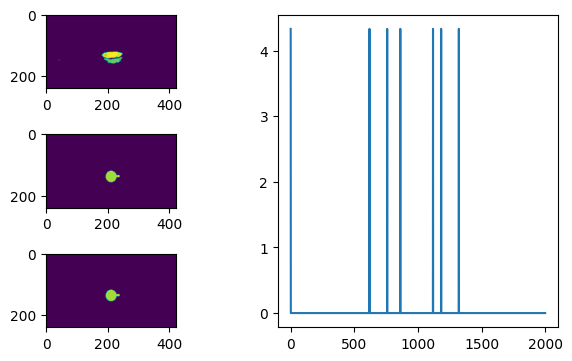

In [27]:
fig, axd = plt.subplot_mosaic([['gt',   'losses'],
                               ['init', 'losses'],
                               ['fin',  'losses']],
                              figsize=(6.0, 3.5), layout="constrained")
axd['gt'].imshow(cleaned_depth_img)
axd['init'].imshow(render_obj_axis_angle(best_init_translation, *best_init_angles, *verts_and_faces_list[best_obj_idx]))
axd['fin'].imshow(render_obj_axis_angle(best_final_translation, *best_final_angles, *verts_and_faces_list[best_obj_idx]))
axd['losses'].plot(best_loss_traj)